In [1]:
import os
import torch

save_dir = os.path.expanduser(os.environ["YOLO_MODELS"])
checkpoint_pth = max([f for f in os.listdir(save_dir) if f.endswith(".pth")])

In [2]:
from models import YOLOv1
from data.VOC_Dataset import VOC_Dataset
from data import DATA_HOME

from ipdb import set_trace
from torch.utils.data import DataLoader
from numpy import array
from multiprocessing import cpu_count
import random 
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

random.seed(1)
torch.manual_seed(1)

In [3]:
import platform

_voc_root = f"{DATA_HOME}/VOCdevkit/VOC2007"
voc_ds = VOC_Dataset(_voc_root)
BS = 1

def collate_fn(data):
    # output: 7 * 7 * 30
    # S * S * ((x, y, w, h, confidence) * B=2 + C=20)
    # make img batch and label batch
    imgs, labels, classes = zip(*data)
    # inhomegenous shape label, since each image has different number of objects
    # label's dimension: (Batch size, # of objects in each image, 4 coords)
    return torch.tensor(array(imgs), dtype=torch.float), labels, classes
    
if platform.system() == "Windows":
    loader = DataLoader(voc_ds, batch_size=BS, pin_memory=True, shuffle=True, collate_fn=collate_fn)
else:
    loader = DataLoader(voc_ds, batch_size=BS, pin_memory=True, shuffle=True, num_workers=4, collate_fn=collate_fn)

class dict:  {'aeroplane': 0, 'dog': 1, 'motorbike': 2, 'bicycle': 3, 'train': 4, 'bottle': 5, 'cat': 6, 'bus': 7, 'sofa': 8, 'sheep': 9, 'horse': 10, 'boat': 11, 'car': 12, 'diningtable': 13, 'person': 14, 'chair': 15, 'cow': 16, 'tvmonitor': 17, 'bird': 18, 'pottedplant': 19}


In [4]:
yolo = YOLOv1().to(device=device)

S = 7 # num of rows/cols
C = 20 # num of classes
B = 2 # num of bounding boxes

lamba_coord = 5
lamba_noobj = 0.5

In [5]:
from utils.display import display_image_bbox
from utils.metrics import xywh_2_xxyy
import numpy as np

with torch.no_grad():
    for _, (batch, labels, classes) in enumerate(loader):
        res = yolo(batch.to(device=device)).squeeze(0)
        set_trace()
        boxes = []
        for i in range(res.shape[1]):
            for j in range(res.shape[2]):
                cell1 = res[:, i, j][:5]
                cell2 = res[:, i, j][5:10]
                boxes.append(cell1.detach().cpu().numpy())
                boxes.append(cell2.detach().cpu().numpy())
                

        boxes = list(map(xywh_2_xxyy, boxes))

        boxes = [np.maximum(.0, np.array(b)) * 100 for b in boxes]
        boxes = [(min(b[0], b[2]), min(b[1], b[3]), b[2], b[3]) for b in boxes]
        display_image_bbox(batch[0], boxes)

> c:\users\sxing\appdata\local\temp\ipykernel_18736\556098898.py(9)<module>()

tensor([[[-8.2754e-03, -1.4265e-02, -7.2528e-03,  ..., -3.9033e-03,
          -1.9112e-03, -4.0799e-03],
         [-1.3321e-02, -9.6641e-03, -4.7833e-03,  ...,  4.2233e-03,
          -1.2514e-02, -1.0486e-02],
         [-5.9658e-03, -4.2881e-03,  3.4645e-03,  ..., -1.1782e-02,
           1.1092e-02, -5.4682e-03],
         ...,
         [-9.9226e-03,  1.2294e-02, -3.5797e-03,  ...,  2.2819e-03,
          -1.2040e-02, -1.2504e-02],
         [ 7.6564e-03, -4.0314e-03,  4.4564e-03,  ...,  1.2894e-02,
           4.0858e-03, -1.3988e-02],
         [-7.0184e-04, -1.3607e-02,  5.1405e-03,  ...,  1.2943e-02,
           9.5065e-03, -1.2328e-02]],

        [[-1.8444e-03,  2.2893e-03,  7.7076e-03,  ...,  5.5042e-03,
           1.7919e-03,  1.6850e-02],
         [ 1.3506e-02,  1.1065e-02, -2.6055e-03,  ..., -1.1958e-02,
          -6.6144e-03,  1.3427e-02],
         [ 5.3584e-03,  4.8059e-03, -1.0205e-03,  ...,  4.2647e-0

loss_df:               l1         l2        l3        l4        l5
0      2.536934  29.511324  0.000276  0.008632  2.006200
1     30.862514  91.090057  0.000496  0.008388  7.066406
2      4.314138  30.672049  0.000919  0.008283  3.072291
3     18.463764  69.706085  0.001361  0.007788  5.014307
4      2.048713  37.579781  0.000364  0.008573  3.014718
...         ...        ...       ...       ...       ...
8012   2.011063   3.067562  1.225315  0.647013  6.482408
8013   0.326086   1.712719  0.114641  0.894343  1.521894
8014   1.774904   1.981506  0.876175  0.817015  6.567805
8015   0.953539   0.441451  0.534170  0.737899  6.054998
8016   2.974952   3.964569  2.226439  0.603577  6.865170

[8017 rows x 5 columns]


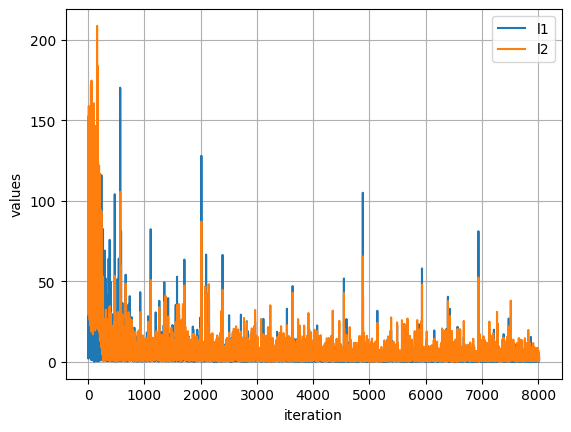

loss_df:               l1         l2        l3        l4         l5
0     21.844217  65.849945  0.000947  0.007921   6.005747
1      5.915444  33.682320  0.000332  0.008850   2.989771
2     12.476767  63.850315  0.000709  0.008551   5.031264
3     22.752455  82.194977  0.000756  0.008335   7.024859
4      0.953150  30.156544  0.000228  0.008241   2.023383
...         ...        ...       ...       ...        ...
8012   1.015757   2.603884  0.030662  1.001288   3.930264
8013   3.935031   4.819430  0.780512  0.687755   5.819773
8014   2.843581   3.083851  1.107070  0.772714  10.655581
8015   0.462540   1.006664  0.401126  0.675643   2.824010
8016   1.726466   1.392522  0.981101  0.883731   8.727905

[8017 rows x 5 columns]


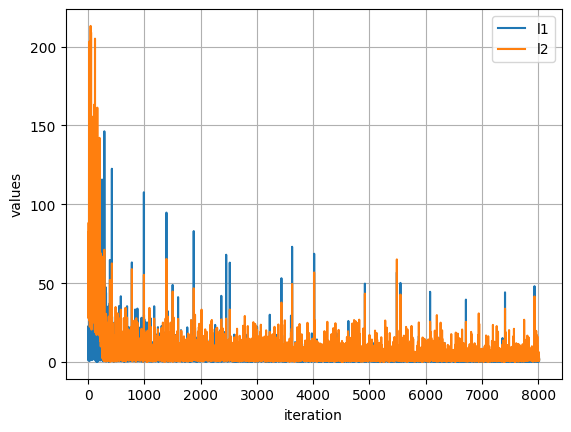

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
loss_dir = os.path.expanduser("~/Downloads")
for fname in ["/train_loss_latest.csv", "/val_loss_latest.csv"]:
    loss_df = pd.read_csv(loss_dir + fname, index_col=0)
    print("loss_df: ", loss_df)
    for col in loss_df.columns:
        if col == "l1" or col == "l2":
            plt.plot(loss_df[col], label=col)
    plt.xlabel("iteration")
    plt.ylabel("values")
    plt.legend()
    plt.grid(True)
    plt.show()